In [1]:
import pandas as pd
import random
import math

import torch
import torch.optim as optim
import numpy as np

from arms.bernoulli import BernoulliArm
%matplotlib inline

In [2]:
class DeepBanditPytorch():
    def __init__(self, num_bandits):
        self.num_bandits = num_bandits
    
    def initialize(self, num_bandits):
        self.counts = 1
        self.weights = torch.ones(num_bandits,requires_grad=True)
        self.optimizer = optim.Adam([self.weights], lr=0.01, betas=(0.9, 0.999))
    
    def select_arm(self):
        epsilon = 1 / (5 * math.log(self.counts + 0.0000001))
        if np.random.rand(1) < epsilon:
            action = np.random.randint(self.num_bandits)
        else:
            action = torch.argmax(self.weights,0)
        return action

  
    def update(self, chosen_arm, reward):
        if reward == 0:
            reward = -1
            
        responsible_weight = self.weights[chosen_arm]
        loss = -(torch.log(responsible_weight)*reward)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.counts += 1

In [3]:
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm = np.argmax(means)
print("Best arm is " + str(best_arm))

Best arm is 2


In [4]:
from testing_framework.tests import *

algo = DeepBanditPytorch(n_arms)
results = test_algorithm(algo, arms, 5000, 250)
dataframe = pd.DataFrame(np.array(results).T,columns=["Sim", "T", "ChosenArm", "Reward", "CumulativeReward"])

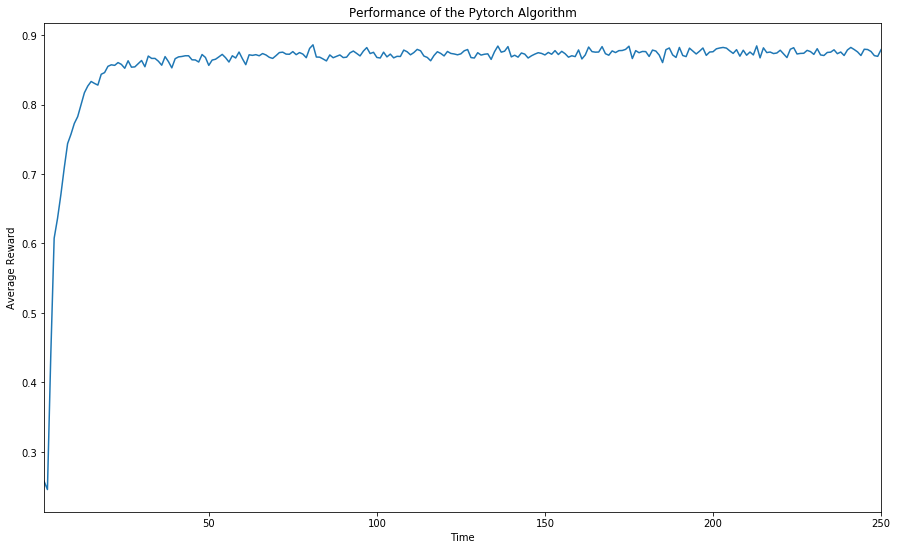

In [5]:
ax = dataframe.groupby("T").mean()['Reward'].plot(figsize=(15,9))
ax.set_title("Performance of the Pytorch Algorithm")
ax.set_ylabel('Average Reward');
ax.set_xlabel('Time');

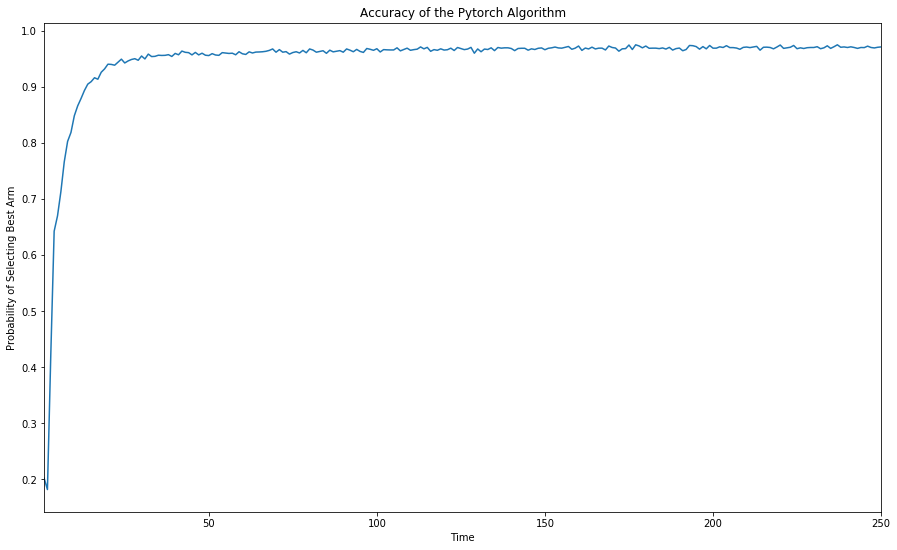

In [6]:
df_grouped = dataframe.groupby(["T","ChosenArm"]).count()/dataframe.Sim.max()
df_grouped = df_grouped.reset_index()
ax = df_grouped[df_grouped['ChosenArm'] == float(best_arm)].set_index('T')['Reward'].plot(figsize=(15,9))
ax.set_title("Accuracy of the Pytorch Algorithm")
ax.set_ylabel('Probability of Selecting Best Arm');
ax.set_xlabel('Time');

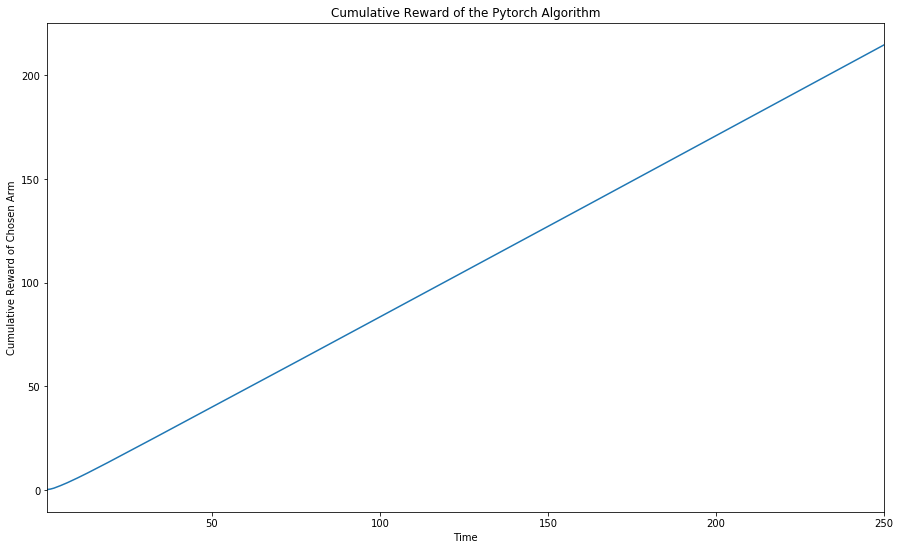

In [7]:
ax = dataframe.groupby("T").mean()['CumulativeReward'].plot(figsize=(15,9))
ax.set_title("Cumulative Reward of the Pytorch Algorithm")
ax.set_ylabel('Cumulative Reward of Chosen Arm');
ax.set_xlabel('Time');

In [9]:
dataframe.to_csv("Pytorch_results.csv",index=None)